<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Lachin Naghashyar
### Student Number : 98110179
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
import torchvision
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [5]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_data, batch_size=16, shuffle=False, num_workers=2)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1acQve-TOYd6wYtogpHCblhoDZt9jWQdf/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [6]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):

     def __init__(self):
        super(ResidualClassifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size = 3, stride=1, padding = 1),   #padding = (kernel - stride) /2                           
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),     
            nn.ReLU(),                 
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),     
            nn.ReLU()              
        )
        self.conv3 = nn.Sequential(        
            nn.MaxPool2d(kernel_size=2, stride=2),     
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1),     
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),     
            nn.ReLU(),                 
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),     
            nn.ReLU()              
        )
        self.out = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), 
            nn.Linear(64, 10)
        )
    

     def forward(self, x):
        res1 = self.conv1(x)
        out1 = res1 + self.conv2(res1)
        res2 = self.conv3(out1)
        out2 = res2 + self.conv4(res2)
        return self.out(out2)

# Train Model (30 Points)

In [7]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.0005, momentum = 0.95)

In [8]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
# Measure the validation loss and accuracy
def validation(model, dataloader, criterion, device):
    loss = 0
    accuracy = 0
    with torch.no_grad():
        for images, labels in dataloader:
            
            images, labels = images.to(device), labels.to(device) # Move input and label tensors to the GPU
            
            output = model.forward(images)
            loss += criterion(output, labels).item()

            ps = torch.exp(output) # get the class probabilities from log-softmax
            equality = (labels.data == ps.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
            # del images, labels, output
    
    return loss, accuracy  


total_step = len(train_loader)
num_epochs = 20
running_loss = 0.0
train_accuracy = 0
train_loss = []
train_acc = [] 
val_loss = []
val_accs = []

for e in range(num_epochs):

    model.train()
    for images, labels in train_loader:
        images, labels= images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        ps = torch.exp(output) 
        equality = (labels.data == ps.max(1)[1])
        train_accuracy += equality.type(torch.FloatTensor).mean()
        train_loss.append(running_loss)
        train_acc.append(train_accuracy)
        # del images, labels, output
        # torch.cuda.empty_cache()

    model.eval() 

    with torch.no_grad():
        valid_loss, val_acc = validation(model, val_loader, criterion, device)
        val_loss.append(valid_loss)
        val_accs.append(val_acc)
        

        print("Epoch: {}/{}.. ".format(e+1, num_epochs),
              "Training Loss: {:.3f}.. ".format(running_loss),
              "Training Accuracy: {:.3f}".format(train_accuracy/len(train_loader)),
              "Validation Loss: {:.3f}.. ".format(valid_loss/len(val_loader)),
              "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)))

        running_loss = 0.0
        train_accuracy = 0
        model.train() 

Epoch: 1/20..  Training Loss: 3248.294..  Training Accuracy: 0.627 Validation Loss: 0.250..  Validation Accuracy: 0.919
Epoch: 2/20..  Training Loss: 500.968..  Training Accuracy: 0.952 Validation Loss: 0.099..  Validation Accuracy: 0.969
Epoch: 3/20..  Training Loss: 342.450..  Training Accuracy: 0.967 Validation Loss: 0.092..  Validation Accuracy: 0.973
Epoch: 4/20..  Training Loss: 268.667..  Training Accuracy: 0.973 Validation Loss: 0.084..  Validation Accuracy: 0.978
Epoch: 5/20..  Training Loss: 222.242..  Training Accuracy: 0.978 Validation Loss: 0.074..  Validation Accuracy: 0.977
Epoch: 6/20..  Training Loss: 194.566..  Training Accuracy: 0.981 Validation Loss: 0.055..  Validation Accuracy: 0.982
Epoch: 7/20..  Training Loss: 170.148..  Training Accuracy: 0.983 Validation Loss: 0.053..  Validation Accuracy: 0.983
Epoch: 8/20..  Training Loss: 153.153..  Training Accuracy: 0.986 Validation Loss: 0.071..  Validation Accuracy: 0.977
Epoch: 9/20..  Training Loss: 136.482..  Traini

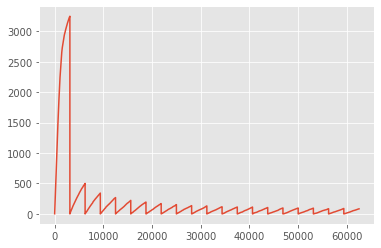

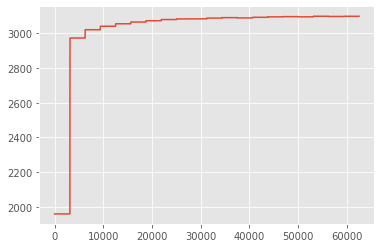

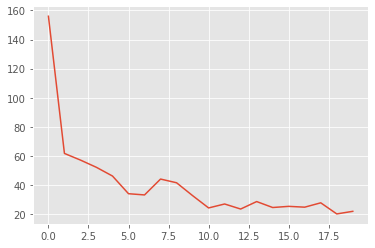

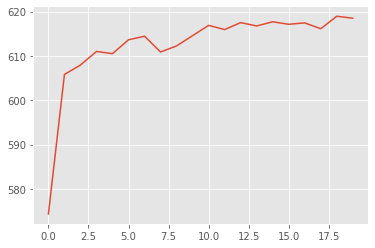

In [9]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.plot(train_loss)
plt.show()
plt.plot(train_acc)
plt.show()
plt.plot(val_loss)
plt.show()
plt.plot(val_accs)
plt.show()

# Test Model (20 Points)

10000


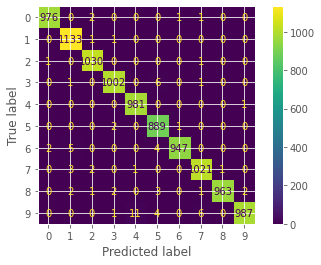

In [10]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in iter(test_loader):
        images,labels = images.to(device), labels.to(device) # Move input and label tensors to the GPU
        output = model.forward(images)
        predicted = torch.max(torch.exp(output), 1)[1]
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()